<a href="https://colab.research.google.com/github/raoshilpa/ee188project2/blob/master/Task2and3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [113]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [114]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')

pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

#NOTE TASK 3: decode_predictions needs to be changed

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [115]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

  #NOTE TASK 3: CHANGE MOBILENET TO MODEL OF CHOICE ^ //wherever mobilenet is called

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [116]:
image_raw = tf.io.read_file('/content/goldfinch.jpeg') #CHANGE
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

Text(0.5, 1.0, 'goldfinch : 83.43% Confidence')

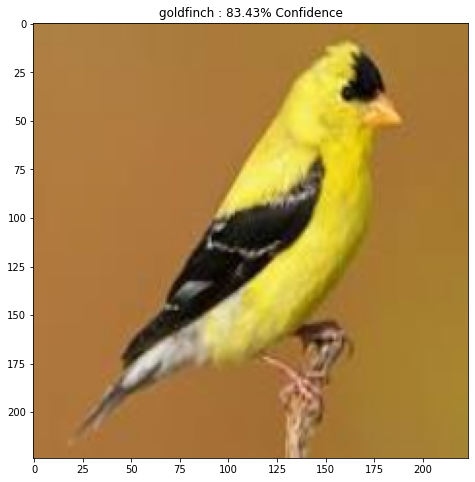

In [117]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
# plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [118]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

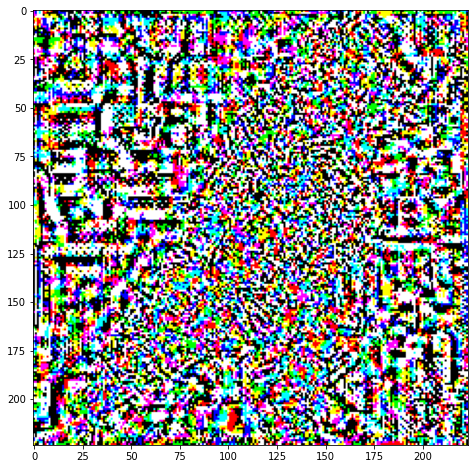

In [119]:
# Get the input label of the image.
giant_panda_index = 11 #CHANGE
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [120]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [121]:
# epsilons = [0, 0.01, 0.1, 0.15] #CHANGE - make for loop, update by 0.01/0.001
x = 0
epsilons=[]
for i in range(0):    #range 0 to prevent for loop from running 
    epsilons.append(x)
    x = x + 0.01

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

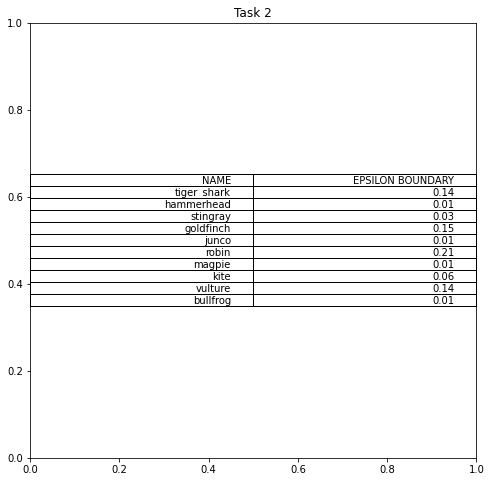

In [122]:
fig, ax = plt.subplots()
plt.title("Task 2")

#create values for table
table_data=[
  ["NAME","EPSILON BOUNDARY"],
  ["tiger_shark",0.14],
  ["hammerhead",0.01], 
  ["stingray",0.03],
  ["goldfinch",0.15],
  ["junco",0.01],
  ["robin",0.21],
  ["magpie",0.01],
  ["kite",0.06],
  ["vulture",0.14],
  ["bullfrog",0.01]
]

#create table
table = ax.table(cellText=table_data, loc='center')
plt.show()

# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


<Figure size 576x576 with 0 Axes>

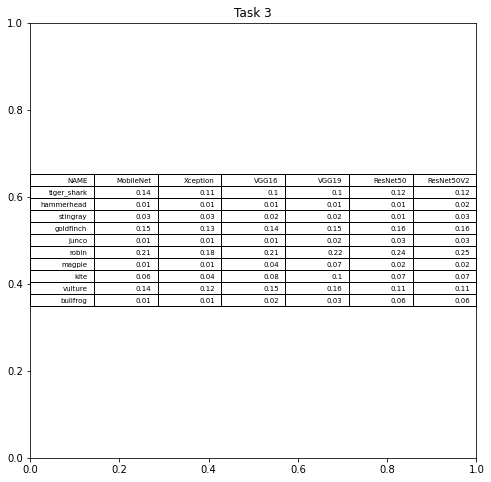

In [139]:
#@title Default title text
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image
# from keras.applications.ResNet50V2 import preprocess_input
# preprocess = tf.keras.applications.resnet_v2.preprocess_input

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

#CHANGE 
pretrained_model = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

pretrained_model.trainable = False

# ImageNet labels
#CHANGE
# decode_predictions = tf.keras.applications.ResNet50V2.decode_predictions


# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  # image = tf.keras.applications.ResNet50V2.preprocess_input(image)
  image = image[None, ...]
  return image

  #TASK 3: CHANGE

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

image_raw = tf.io.read_file('/content/goldfinch.jpeg') #CHANGE
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

plt.figure()
# plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
# _, image_class, class_confidence = get_imagenet_label(image_probs)
# plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
# plt.show() #COMMENTED OUT FOR NOW

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

# Get the input label of the image.
giant_panda_index = 11 #CHANGE
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
# plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  # plt.imshow(image[0]*0.5+0.5)
  # plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                  #  label, confidence*100))
  # plt.show()

# epsilons = [0, 0.01, 0.1, 0.15] #CHANGE - make for loop, update by 0.01/0.001
x = 0
epsilons=[]
for i in range(20):    
    epsilons.append(x)
    x = x + 0.01

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  # display_images(adv_x, descriptions[i])

fig, ax = plt.subplots()
plt.title("Task 3")

#FINAL TABLE WITH DATA AFTER ALL 50 TESTS
table_data=[
  ["NAME","MobileNet", "Xception", "VGG16", "VGG19", "ResNet50", "ResNet50V2"],
  ["tiger_shark",0.14,0.11,0.1,0.1,0.12,0.12],
  ["hammerhead",0.01,0.01,0.01,0.01,0.01,0.02], 
  ["stingray",0.03,0.03,0.02,0.02,0.01,0.03],
  ["goldfinch",0.15,0.13,0.14,0.15,0.16,0.16],
  ["junco",0.01,0.01,0.01,0.02,0.03,0.03],
  ["robin",0.21,0.18,0.21,0.22,0.24,0.25],
  ["magpie",0.01,0.01,0.04,0.07,0.02,0.02],
  ["kite",0.06,0.04,0.08,0.1,0.07,0.07],
  ["vulture",0.14,0.12,0.15,0.16,0.11,0.11],
  ["bullfrog",0.01,0.01,0.02,0.03,0.06,0.06]
]

#create table
table = ax.table(cellText=table_data, loc='center')
plt.show()

What do you observe? Why do you think this is the case?

I observed that the models more or less performed the same, though certain models performed worse in some cases and better in other cases. Xception seemed to perform worse, in general, or on par to the original model, MobileNet. VGG19 performed better on average than VGG16, and I observed a similar pattern when comparing ResNet50V2 to ResNet50. This makes sense, as VGG19 and ResNet50V2 are intended improvements on their counterparts. However, I observed that if given a grainy or otherwise poor quality image, the intended improvements on these v2 models are lesser, and the models perform more or less the same. I found this interesting - my hypothesis is that this occurs because the image must be good quality in order for the optimizations to perform their best. 

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 

MY ANSWERS:
